<a href="https://colab.research.google.com/github/machine-learning-airu-ozone/ChE_Utah_AirQuality_ML_Ozone/blob/master/Investigate_Small_Neural_Network_Performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](https://)
# Investigate Small Neural Network
## Summer 2019-Air U Project 
### Timothy Quah

This script was used to investigate the minimal number of nodes and layers

###  Load Data into Google Colab

First thing we must do is to load our data into the Google Colab environment. To do this we must do the following:
First we need to mount the drive which we use the following lines to do. There are ways to automate this process, but I am honestly a bit too lazy to do this.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The next step we will do is to verify that the path exist to our files that we have stored on google drive. 

In [0]:
import os
# import data
import_data_path = '/content/drive/My Drive/AirQuality_Research/Remove_Params_Upload_GoogleDrive/SWD/'
import_script_path = '/content/drive/My Drive/AirQuality_Research/Functions/'

print('Does Data Path? '+str(os.path.exists(import_data_path)))
print('Does Function Path? '+str(os.path.exists(import_script_path)))

Does Data Path? True
Does Function Path? True


Next we import all the packages we need. If you need a specific version it is possible, but will take an extra line: example  !pip install seaborn==0.9.0


In [0]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras.optimizers as optimizers
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import random
from copy import deepcopy
from keras import backend as K


Now we need to load some scripts from our custom made functions into the enviroment

In [0]:
os.chdir(import_script_path)
from Trainer_Functions import r2_keras,model_neural_network,load_evaluate_neural_net,norm_divider,divider_XY,mse,r2


This function is used to generate the exported textfile 

In [0]:
def export_text(data,name_list,layers,repeat):
    name = 'layers_'+str(layers)+'_low_node_repeat_'+str(repeat)+'.txt'
    text_file = open(name,'w')
    for i in name_list:
        text_file.write(i)
        text_file.write(' ')
        
    row,column = data.shape
    for i in range(0,row,1):
        text_file.write('\n')
        for j in range(0,column,1):
            text_file.write(str(data[i,j]))
            text_file.write(' ')
    text_file.close()
    return name


Next we need to just make sure to close all plots and just in case we have set random seeds


In [0]:
plt.close('all')
load_data_list = os.listdir(import_data_path)
print(load_data_list)

['outsider_data.csv', 'train_validate_data.csv']


We see in this case we have two files one called 'All_Data_norm.csv' we will load both files (including 'train_validate_data.csv') now

In [0]:
i = 1
full_path = os.path.join(import_data_path,load_data_list[i])
df = pd.read_csv(full_path)
header =list(df) 


Now we need to decide which parameters we want to include in the Neural Network. For the sake of the template/tutorial we will keep everything with the exception of  NO2/CO value from DAQ


In [0]:
print(header)
print(len(header))

['Day', 'Hour', 'Month', 'CO_AIR_U_Sensor', 'Humidity_AIR_U_Sensor', 'MICS_AIR_U_Sensor', 'NO_AIR_U_Sensor', 'O3 Value', 'PM10_AIR_U_Sensor', 'PM1_AIR_U_Sensor', 'RH Value', 'SR Value', 'SWS Value', 'TEMP Value', 'Temperature_AIR_U_Sensor', 'Min_CO_AIR_U_Sensor', 'Max_CO_AIR_U_Sensor', 'Min_Humidity_AIR_U_Sensor', 'Max_Humidity_AIR_U_Sensor', 'Min_MICS_AIR_U_Sensor', 'Max_MICS_AIR_U_Sensor', 'Min_NO_AIR_U_Sensor', 'Max_NO_AIR_U_Sensor', 'Min_PM10_AIR_U_Sensor', 'Max_PM10_AIR_U_Sensor', 'Min_PM1_AIR_U_Sensor', 'Max_PM1_AIR_U_Sensor', 'Min_Temperature_AIR_U_Sensor', 'Max_Temperature_AIR_U_Sensor']
29


Now we need to divide the training data from the validation data as well as inputs from outputs. In this case we will set up 70% training and 30% Validation.


---



In [0]:
na_len = 20
nodes_array = np.linspace(6,150,na_len,dtype=int)
layer = 4
learning_rate = 0.05
epochs = 20
batchsize = 32
droprate = 0.2
repeat = 5

In [0]:
header_num = len(header)
Full_List = list(np.arange(0,header_num-1+1e-6,1,dtype=int))
Y_Loc =  header.index('O3 Value')
Y_header_list = []
Y_header_list.append(Y_Loc)
X_header_list = list(set(Full_List)-set(Y_header_list))
data_array = np.array(df)
train_list,valid_list = norm_divider(data_array)
X,Y,X_valid,Y_valid = divider_XY(X_header_list,Y_header_list,data_array,train_list,valid_list)
mse_mean_array = np.zeros(na_len)
r2_mean_array = np.zeros(na_len)
mse_std_array = np.zeros(na_len)
r2_std_array = np.zeros(na_len)


Now we need to specify the neural network archetecture (layers (how deep) and nodes (how wide)), the learning rate (how aggressive the optimizer is),  how long to train, and batch sizes. Finally we want to use the validation data to evaluate the neural network.


In [0]:
for i in range(0,na_len,1):
  print('i = %d'%i)
  mse_temp = np.zeros(repeat)
  r2_temp = np.zeros(repeat)
  for j in range(0,repeat,1):
    K.clear_session()
    nodes = nodes_array[i]

    input_dim_ = len(X_header_list)
    output_dim_ = len(Y_header_list)
    model = model_neural_network(layer,nodes,input_dim_,output_dim_,DropPercent = droprate)
    optimizers.Adam(lr=learning_rate)
    model.compile(loss='mean_squared_error',optimizer="adam", metrics=[r2_keras])
    history = model.fit(x=X, y = Y, nb_epoch=epochs, batch_size=batchsize,verbose = 0)
    Y_pred = model.predict(X_valid)
    mse_temp[j] = mse(Y_valid,Y_pred)
    r2_temp[j] = r2(Y_valid,Y_pred)
    print('j = %d'%j)
  mse_mean_array[i] = np.mean(mse_temp)
  r2_mean_array[i] = np.mean(r2_temp)
  mse_std_array[i] = np.std(mse_temp)
  r2_std_array[i] = np.std(r2_temp)


i = 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


j = 0
j = 1
j = 2
j = 3
j = 4
i = 1
j = 0
j = 1
j = 2
j = 3
j = 4
i = 2
j = 0
j = 1
j = 2
j = 3
j = 4
i = 3
j = 0
j = 1
j = 2
j = 3
j = 4
i = 4
j = 0
j = 1
j = 2
j = 3
j = 4
i = 5
j = 0
j = 1
j = 2
j = 3
j = 4
i = 6
j = 0
j = 1
j = 2
j = 3
j = 4
i = 7
j = 0
j = 1
j = 2
j = 3
j = 4
i = 8
j = 0
j = 1
j = 2
j = 3
j = 4
i = 9
j = 0
j = 1
j = 2
j = 3
j = 4
i = 10
j = 0
j = 1
j = 2
j = 3
j = 4
i = 11
j = 0
j = 1
j = 2
j = 3
j = 4
i = 12
j = 0
j = 1
j = 2
j = 3
j = 4
i = 13
j = 0
j = 1
j = 2
j = 3
j = 4
i = 14
j = 0
j = 1
j = 2
j = 3
j = 4
i = 15
j = 0
j = 1
j = 2
j = 3
j = 4
i = 16
j = 0
j = 1
j = 2
j = 3
j = 4
i = 17
j = 0
j = 1
j = 2
j = 3
j = 4
i = 18
j = 0
j = 1
j = 2
j = 3
j = 4
i = 19
j = 0
j = 1
j = 2
j = 3
j = 4


[  6  13  21  28  36  43  51  59  66  74  81  89  96 104 112 119 127 134
 142 150]
[0.02082666 0.0126863  0.01558953 0.01171369 0.00998424 0.01023454
 0.0088358  0.00823889 0.0087599  0.00796446 0.0080577  0.00795954
 0.00722067 0.00762206 0.00757577 0.00701721 0.00699189 0.00707636
 0.00710349 0.00664142]
[0.62259592 0.77010907 0.7174991  0.78773397 0.81907366 0.81453792
 0.83988477 0.8507014  0.84126019 0.85567445 0.85398488 0.85576351
 0.86915276 0.86187916 0.86271799 0.87283978 0.87329857 0.87176794
 0.87127625 0.87964942]


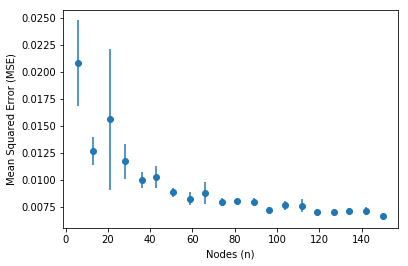

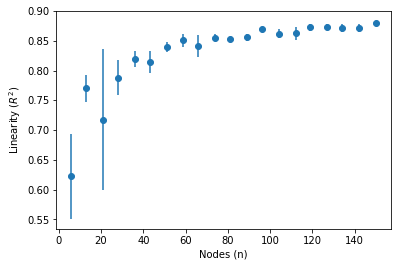

In [0]:
from google.colab import files

fig = plt.figure()
plt.errorbar(nodes_array, mse_mean_array, mse_std_array,fmt='o')
plt.xlabel('Nodes (n)')
plt.ylabel('Mean Squared Error (MSE)')

name = str(layer)+'_MSE_Nodes_Study.jpg'
plt.savefig(name,dpi=300)
files.download(name)

plt.figure()
plt.errorbar(nodes_array, r2_mean_array, r2_std_array,fmt='o')
plt.xlabel('Nodes (n)')
plt.ylabel('Linearity ($R^2$)')

name = str(layer)+'_R2_Nodes_Study.jpg'
plt.savefig(name,dpi=300)
files.download(name)

print(nodes_array)
print(mse_mean_array)
print(r2_mean_array)

In [0]:
data = np.vstack([nodes_array,mse_mean_array,mse_std_array,r2_mean_array,r2_std_array]).transpose()
name_list = ['Nodes','MSE_Mean','MSE_StD','R2_Mean','R2_StD']
name =export_text(data,name_list,layer,repeat)
files.download(name)


MessageError: ignored